<a href="https://colab.research.google.com/github/Msaroj123/Sanskrit-Bytes/blob/main/sanskrit_bytes_symmetric_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import nltk
import nltk.translate.chrf_score as chrf
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from nltk.tokenize import word_tokenize
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import os
from nltk.translate import meteor_score
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
import matplotlib.pyplot as plt
import pandas as pd

class CustomDataset(Dataset):
    def __init__(self, texts, descriptions, tokenizer):
        self.tokenizer = tokenizer
        self.texts = texts
        self.descriptions = descriptions

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        description = self.descriptions[index]
        encoded = self.tokenizer.encode_plus(
            text,
            padding='max_length',
            truncation=True,
            max_length=50,
            return_tensors='pt',
            add_special_tokens=True
        )
        input_ids = encoded['input_ids'].squeeze()
        attention_mask = encoded['attention_mask'].squeeze()
        encoded_description = self.tokenizer.encode_plus(
            description,
            padding='max_length',
            truncation=True,
            max_length=50,
            return_tensors='pt',
            add_special_tokens=True
        )
        target_ids = encoded_description['input_ids'].squeeze()
        return input_ids, attention_mask, target_ids, text, description

def calculate_lepor(references, predictions):
    lepor_scores = []
    for ref, pred in zip(references, predictions):
        ref_tokens = word_tokenize(ref.lower())
        pred_tokens = word_tokenize(pred.lower())

        ref_len = len(ref_tokens)
        pred_len = len(pred_tokens)

        lepor = (1 - abs(pred_len - ref_len) / max(ref_len, pred_len)) * sentence_bleu([ref_tokens], pred_tokens)
        lepor_scores.append(lepor)

    return lepor_scores

def calculate_symmetric_similarity(text1, text2):
    """
    Calculate symmetric similarity between two texts using multiple metrics
    """
    def tokenize(text):
        return set(word_tokenize(text.lower()))

    # Tokenize both texts
    tokens1 = tokenize(text1)
    tokens2 = tokenize(text2)

    # Calculate Jaccard similarity
    intersection = len(tokens1.intersection(tokens2))
    union = len(tokens1.union(tokens2))
    jaccard = intersection / union if union > 0 else 0

    # Calculate Dice coefficient
    dice = (2 * intersection) / (len(tokens1) + len(tokens2)) if (len(tokens1) + len(tokens2)) > 0 else 0

    # Calculate overlap coefficient
    overlap = intersection / min(len(tokens1), len(tokens2)) if min(len(tokens1), len(tokens2)) > 0 else 0

    return {
        'jaccard': jaccard,
        'dice': dice,
        'overlap': overlap
    }

def calculate_average_symmetric_scores(references, predictions):
    """
    Calculate average symmetric similarity scores for a corpus
    """
    scores = {
        'jaccard': [],
        'dice': [],
        'overlap': []
    }

    for ref, pred in zip(references, predictions):
        similarity_scores = calculate_symmetric_similarity(ref, pred)
        for metric, score in similarity_scores.items():
            scores[metric].append(score)

    return {
        metric: sum(score_list) / len(score_list)
        for metric, score_list in scores.items()
    }

def train():
    # Set your custom dataset paths
    train_dataframe = ramayan.iloc[:200,:2]
    test_dataframe = ramayan.iloc[:200:,:2]

    # Extract texts and descriptions from the DataFrame
    train_texts = train_dataframe['content'].tolist()
    train_descriptions = train_dataframe['explanation'].tolist()
    test_texts = test_dataframe['content'].tolist()
    test_descriptions = test_dataframe['explanation'].tolist()

    # Load pre-trained GPT-2 model and tokenizer
    model = GPT2LMHeadModel.from_pretrained('gpt2')
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    # Add a padding token to the tokenizer
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

    # Load and tokenize custom datasets
    train_dataset = CustomDataset(train_descriptions, train_texts, tokenizer)
    test_dataset = CustomDataset(test_descriptions, test_texts, tokenizer)
    train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)

    # Set device (GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Set hyperparameters
    epochs = 5
    learning_rate = 0.0001

    # Set optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for input_ids, attention_mask, target_ids, _, _ in train_dataloader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            target_ids = target_ids.to(device)

            optimizer.zero_grad()

            outputs = model(input_ids, attention_mask=attention_mask, labels=target_ids)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{epochs} - Average Loss: {avg_loss:.4f}")

    # Evaluation loop
    model.eval()
    references = []
    predictions = []

    with torch.no_grad():
        for input_ids, attention_mask, _, texts, descriptions in test_dataloader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            generated_ids = model.generate(input_ids, attention_mask=attention_mask, max_new_tokens=100)
            generated_texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in generated_ids]

            references.extend(descriptions)
            predictions.extend(generated_texts)

    # Calculate metrics
    bleu = corpus_bleu([[ref] for ref in test_descriptions], predictions)
    nist = nltk.translate.nist_score.corpus_nist(test_descriptions, predictions)
    lepor_scores = calculate_lepor(test_descriptions, predictions)
    lepor = sum(lepor_scores) / len(lepor_scores)

    # Calculate symmetric similarity scores
    symmetric_scores = calculate_average_symmetric_scores(test_descriptions, predictions)

    # Create DataFrame with all metrics
    final_result = pd.DataFrame({
        'References': references,
        'Actual': test_descriptions,
        'Predictions': predictions,
        'BLEU Score': bleu,
        'NIST Score': nist,
        'LEPOR Score': lepor,
        'Jaccard Similarity': symmetric_scores['jaccard'],
        'Dice Coefficient': symmetric_scores['dice'],
        'Overlap Coefficient': symmetric_scores['overlap']
    })

    # Save results
    csv_file_path = '/content/drive/MyDrive/my drive/update1__.CSV'
    if os.path.exists(csv_file_path):
        os.remove(csv_file_path)
    final_result.to_csv(csv_file_path, index=False)

    # Print all scores
    print("\n-------------------------------------")
    print(f"!!!!!!!!!!!!!!\n!!!!!!!!!!!!!!\nCSV file saved successfully: {csv_file_path}")
    print("\n-------------------------------------")
    print('BLEU Score:', bleu)
    print("\n-------------------------------------")
    print('NIST Score:', nist)
    print("\n-------------------------------------")
    print('LEPOR Score:', lepor)
    print("\n-------------------------------------")
    print("\n-------------------------------------")
    print('Symmetric Similarity Scores:')
    print("\n-------------------------------------")
    print(f"Jaccard Similarity: {symmetric_scores['jaccard']:.4f}")
    print("\n-------------------------------------")
    print(f"Dice Coefficient: {symmetric_scores['dice']:.4f}")
    print("\n-------------------------------------")
    print(f"Overlap Coefficient: {symmetric_scores['overlap']:.4f}")
    print("\n-------------------------------------")

# Load the data and run training
ramayan = pd.read_csv("/content/drive/MyDrive/my drive/ayodhyakand.csv")
ramayan = ramayan.iloc[:100,:2]
ramayan = ramayan.dropna()

# Run the training and evaluation
train()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 1/5 - Average Loss: 4.0261
Epoch 2/5 - Average Loss: 3.1011
Epoch 3/5 - Average Loss: 3.0301
Epoch 4/5 - Average Loss: 3.0153


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Epoch 5/5 - Average Loss: 2.9851


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene


-------------------------------------
!!!!!!!!!!!!!!
!!!!!!!!!!!!!!
CSV file saved successfully: /content/drive/MyDrive/my drive/update1__.CSV

-------------------------------------
BLEU Score: 0.6206048747341989

-------------------------------------
NIST Score: 0.041266569875164145

-------------------------------------
LEPOR Score: 0.8718432819761917

-------------------------------------

-------------------------------------
Symmetric Similarity Scores:

-------------------------------------
Jaccard Similarity: 0.9008

-------------------------------------
Dice Coefficient: 0.9463

-------------------------------------
Overlap Coefficient: 0.9714

-------------------------------------


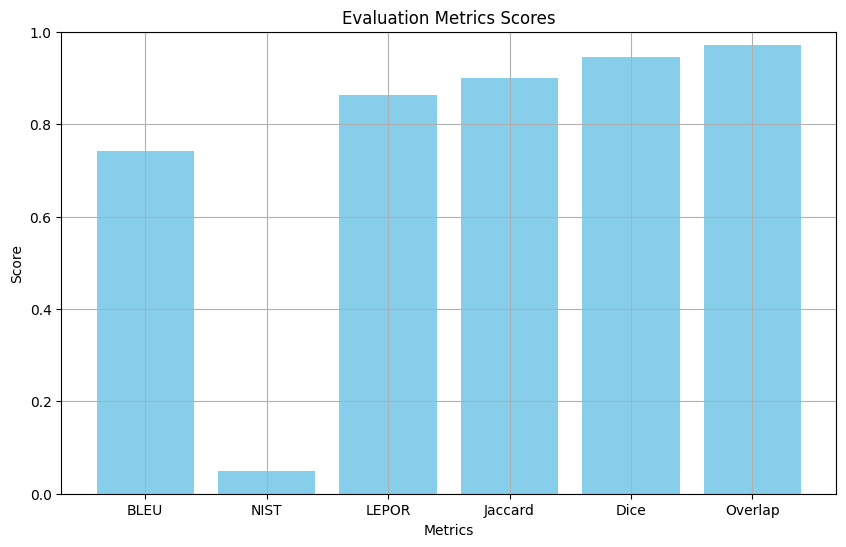

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/my drive/update__.CSV')
# Extract the scores
bleu_score = data['BLEU Score'].values[0]  # Accessing the first value
nist_score = data['NIST Score'].values[0]
lepor_score = data['LEPOR Score'].values[0]
jaccard_similarity = data['Jaccard Similarity'].values[0]
dice_coefficient = data['Dice Coefficient'].values[0]
overlap_coefficient = data['Overlap Coefficient'].values[0]

# Create a bar chart
scores = [bleu_score, nist_score, lepor_score, jaccard_similarity, dice_coefficient, overlap_coefficient]
labels = ['BLEU', 'NIST', 'LEPOR', 'Jaccard', 'Dice', 'Overlap']

plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.bar(labels, scores, color='skyblue')
plt.title('Evaluation Metrics Scores')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Set y-axis limits if necessary
plt.grid(True)  # Add gridlines for better readability
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
